In [20]:
# --- 1. Reikalingos bibliotekos ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import pickle
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f"TensorFlow versija: {tf.__version__}")
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow versija: 2.19.0


In [21]:
# --- 2. Duomenų paruošimas (jei dar nepadaryta) ---
# Naudosime duomenis, kurie jau yra parengti kitų modelių failuose
cached_data_path = os.path.join('..', '..', 'data', 'btc_data_1y_15m.csv')

if os.path.exists(cached_data_path):
    print(f"Naudojami cached duomenys iš {cached_data_path}")
    df = pd.read_csv(cached_data_path)
    df['time'] = pd.to_datetime(df['time'])
    print(f"Duomenų dydis: {df.shape}")
    print(df.head())
else:
    print(f"KLAIDA: Nerastas duomenų failas {cached_data_path}")
    print("Pirma paleiskite modelių apmokymo notebookus, pvz., lstm_model.ipynb")

Naudojami cached duomenys iš ..\..\data\btc_data_1y_15m.csv
Duomenų dydis: (35040, 12)
                 time      open      high       low     close     volume  \
0 2024-05-21 14:00:00  70595.92  70847.77  70560.00  70777.91  584.15346   
1 2024-05-21 14:15:00  70777.91  70833.80  70329.82  70419.44  705.06014   
2 2024-05-21 14:30:00  70419.44  70927.48  70417.79  70456.81  611.94862   
3 2024-05-21 14:45:00  70456.82  70507.24  70187.76  70213.20  756.49794   
4 2024-05-21 15:00:00  70213.21  70342.68  70153.69  70247.83  669.15517   

      close_time  quote_asset_volume  number_of_trades  \
0  1716300899999        4.130733e+07             23464   
1  1716301799999        4.976077e+07             26447   
2  1716302699999        4.323031e+07             28584   
3  1716303599999        5.323694e+07             50211   
4  1716304499999        4.699733e+07             34871   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume  ignore  
0                    307.29840      

In [22]:
# --- 3. Duomenų normalizavimas (jei reikia) ---
# Dažniausiai šis žingsnis jau atliktas modelių apmokymo metu
# Jei reikia, galima pakartoti:

feature_columns = ['open', 'high', 'low', 'close', 'volume']
target_column = 'close'  # Prognozuojame Bitcoin uždarymo kainą

# Jei reikia normalizuoti duomenis
if 'df_normalized' not in locals():
    print("Normalizuojami duomenys...")
    df_normalized = df.copy()
    scaler = MinMaxScaler()
    df_normalized[feature_columns] = scaler.fit_transform(df[feature_columns])
    df_original = df.copy()

In [23]:
# --- 4. Pagalbinės funkcijos ---
def create_sequences(data, target_column, sequence_length):
    """Sukuria sekas iš laiko eilučių duomenų"""
    X, y = [], []
    feature_columns = ['open', 'high', 'low', 'close', 'volume']
    data_array = data[feature_columns].values
    target_idx = feature_columns.index(target_column)
    for i in range(len(data) - sequence_length):
        X.append(data_array[i:i + sequence_length])
        y.append(data_array[i + sequence_length, target_idx])
    return np.array(X), np.array(y)

def inverse_transform_predictions(predictions, scaler, target_idx=3, feature_names=None):
    """Transformuoja prognozes atgal į originalią skalę"""
    dummy = np.zeros((len(predictions), len(feature_names) if feature_names else 5))
    dummy[:, target_idx] = predictions.flatten()
    inverse_predicted = scaler.inverse_transform(dummy)
    return inverse_predicted[:, target_idx]

In [24]:
# --- 5. LSTM modelio įkėlimas ---
try:
    # Įkeliame LSTM modelį
    lstm_model_path = '../../models/lstm_model.h5'
    lstm_model = tf.keras.models.load_model(lstm_model_path)
    print("LSTM modelis įkeltas sėkmingai")
    
    # Įkeliame modelio informaciją
    with open('../../models/lstm_model_info.json', 'r') as f:
        lstm_info = json.load(f)
    print("LSTM modelio informacija įkelta")
    
    # Įkeliame LSTM scaler'į
    with open('../../models/lstm_scaler.pkl', 'rb') as f:
        lstm_scaler = pickle.load(f)
    print("LSTM scaler įkeltas")
    
    lstm_available = True
except Exception as e:
    print(f"Klaida įkeliant LSTM modelį: {e}")
    lstm_available = False

LSTM modelis įkeltas sėkmingai
Klaida įkeliant LSTM modelį: [Errno 2] No such file or directory: '../../models/lstm_model_info.json'


In [25]:
# --- 6. GRU modelio įkėlimas ---
try:
    # Įkeliame GRU modelį
    gru_model_path = '../../models/gru_model.h5'
    gru_model = tf.keras.models.load_model(gru_model_path)
    print("GRU modelis įkeltas sėkmingai")
    
    # Įkeliame modelio informaciją
    with open('../../models/gru_model_info.json', 'r') as f:
        gru_info = json.load(f)
    print("GRU modelio informacija įkelta")
    
    # Įkeliame GRU scaler'į
    with open('../../models/gru_scaler.pkl', 'rb') as f:
        gru_scaler = pickle.load(f)
    print("GRU scaler įkeltas")
    
    gru_available = True
except Exception as e:
    print(f"Klaida įkeliant GRU modelį: {e}")
    gru_available = False

GRU modelis įkeltas sėkmingai
GRU modelio informacija įkelta
Klaida įkeliant GRU modelį: [Errno 2] No such file or directory: '../../models/gru_scaler.pkl'


In [26]:
# --- 7. Transformer modelio įkėlimas ---
try:
    # Įkeliame Transformer modelį
    transformer_model_path = '../../models/transformer_model.h5'
    
    # Apibrėžiame TimeSeriesTransformer klasę ir get_positional_encoding funkciją
    def get_positional_encoding(seq_len, d_model):
        pos = np.arange(seq_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        pos_encoding = np.zeros((seq_len, d_model))
        pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(pos_encoding[np.newaxis, ...], dtype=tf.float32)
    
    class TimeSeriesTransformer(tf.keras.Model):
        def __init__(self, seq_len, num_features, d_model=64, num_heads=4, ff_dim=128, dropout=0.1):
            super().__init__()
            self.seq_len = seq_len
            self.num_features = num_features
            self.d_model = d_model
            self.num_heads = num_heads
            self.ff_dim = ff_dim
            self.dropout_rate = dropout
            
            # Embedding sluoksnis
            self.embedding = layers.Dense(d_model)
            
            # Positional encoding
            self.pos_encoding = get_positional_encoding(seq_len, d_model)
            
            # Multi-head attention
            self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
            self.dropout1 = layers.Dropout(dropout)
            self.norm1 = layers.LayerNormalization(epsilon=1e-6)
            
            # Feed-forward network
            self.ffn = tf.keras.Sequential([
                layers.Dense(ff_dim, activation='relu'),
                layers.Dense(d_model),
            ])
            self.dropout2 = layers.Dropout(dropout)
            self.norm2 = layers.LayerNormalization(epsilon=1e-6)
            
            # Output layers
            self.flatten = layers.Flatten()
            self.out = layers.Dense(1)

        def call(self, x, training=False):
            # Embedding
            x = self.embedding(x)
            
            # Add positional encoding
            x = x + self.pos_encoding
            
            # Multi-head attention
            attn_output = self.attention(x, x)
            attn_output = self.dropout1(attn_output, training=training)
            out1 = self.norm1(x + attn_output)
            
            # Feed-forward network
            ffn_output = self.ffn(out1)
            ffn_output = self.dropout2(ffn_output, training=training)
            out2 = self.norm2(out1 + ffn_output)
            
            # Output
            out2 = self.flatten(out2)
            output = self.out(out2)
            
            return output
        
        def get_config(self):
            config = super().get_config()
            config.update({
                "seq_len": self.seq_len,
                "num_features": self.num_features,
                "d_model": self.d_model,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout": self.dropout_rate,
            })
            return config
    
    # Įkeliame modelį su custom_objects
    transformer_model = tf.keras.models.load_model(
        transformer_model_path,
        custom_objects={'TimeSeriesTransformer': TimeSeriesTransformer}
    )
    print("Transformer modelis įkeltas sėkmingai")
    
    # Įkeliame modelio informaciją
    with open('../../models/transformer_model_info.json', 'r') as f:
        transformer_info = json.load(f)
    print("Transformer modelio informacija įkelta")
    
    # Įkeliame Transformer scaler'į
    with open('../../models/transformer_scaler.pkl', 'rb') as f:
        transformer_scaler = pickle.load(f)
    print("Transformer scaler įkeltas")
    
    transformer_available = True
except Exception as e:
    print(f"Klaida įkeliant Transformer modelį: {e}")
    transformer_available = False

Klaida įkeliant Transformer modelį: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.TimeSeriesTransformer'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of TimeSeriesTransformer from its config.

Received config={'name': 'time_series_transformer_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'seq_len': 24, 'num_features': 5, 'd_model': 64, 'num_heads': 4, 'ff_dim': 128, 'dropout': 0.1}

Error encountered during deserialization: TimeSeriesTransformer.__init__() got an unexpected keyword argument 'name'


In [27]:
# --- 8. ARIMA/Statistinių modelių įkėlimas (jei naudojami) ---
try:
    # Įkeliame ARIMA modelio prognozes ir metrikas (jei yra)
    with open('../../models/arima_model_info.json', 'r') as f:
        arima_info = json.load(f)
    
    # Įkeliame ARIMA prognozes (jei išsaugotos)
    arima_preds_path = '../../models/arima_predictions.npy'
    if os.path.exists(arima_preds_path):
        arima_preds_original = np.load(arima_preds_path)
        print("ARIMA prognozės įkeltos")
    
    arima_available = True
    print("ARIMA modelio informacija įkelta")
except Exception as e:
    print(f"ARIMA modelis neprieinamas: {e}")
    arima_available = False

ARIMA modelis neprieinamas: [Errno 2] No such file or directory: '../../models/arima_model_info.json'


In [28]:
# --- 9. Testavimo duomenų paruošimas ---
# Naudojame paskutinius 20% duomenų kaip testavimo rinkinį
X_test_indices = None
test_dates = None

if lstm_available:
    # Naudojame parametrus iš LSTM modelio
    sequence_length = lstm_info.get('sequence_length', 10)
    if 'df_normalized' in locals():
        X, y = create_sequences(df_normalized, target_column, sequence_length)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Išsaugome testavimo indeksus ir datas
        X_test_indices = slice(-len(X_test), None)
        test_dates = df['time'].iloc[sequence_length + X_test_indices.start:].reset_index(drop=True)
        
        print(f"Testavimo duomenų paruošti: X_test.shape={X_test.shape}, y_test.shape={y_test.shape}")
elif gru_available:
    # Naudojame parametrus iš GRU modelio
    sequence_length = gru_info.get('sequence_length', 10)
    if 'df_normalized' in locals():
        X, y = create_sequences(df_normalized, target_column, sequence_length)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        # Išsaugome testavimo indeksus ir datas
        X_test_indices = slice(-len(X_test), None)
        test_dates = df['time'].iloc[sequence_length + X_test_indices.start:].reset_index(drop=True)
        
        print(f"Testavimo duomenų paruošti: X_test.shape={X_test.shape}, y_test.shape={y_test.shape}")
else:
    print("ĮSPĖJIMAS: Nėra jokių modelių, negalima paruošti testavimo duomenų.")

ĮSPĖJIMAS: Nėra jokių modelių, negalima paruošti testavimo duomenų.


In [29]:
# --- 10. Prognozių generavimas (LSTM) ---
lstm_preds_original = None

if lstm_available and 'X_test' in locals():
    print("Generuojamos LSTM prognozės...")
    lstm_preds = lstm_model.predict(X_test)
    
    # Transformuojame atgal į originalią skalę
    target_idx = feature_columns.index(target_column)
    lstm_preds_original = inverse_transform_predictions(
        lstm_preds, lstm_scaler, target_idx, feature_columns
    )
    
    # Atstatome y_test į originalią skalę, jei dar neatstatyta
    if 'y_test_original' not in locals():
        y_test_original = inverse_transform_predictions(
            y_test.reshape(-1, 1), lstm_scaler, target_idx, feature_columns
        )
    
    print(f"LSTM prognozės sugeneruotos, forma: {lstm_preds_original.shape}")

In [30]:
# --- 11. Prognozių generavimas (GRU) ---
gru_preds_original = None

if gru_available and 'X_test' in locals():
    print("Generuojamos GRU prognozės...")
    gru_preds = gru_model.predict(X_test)
    
    # Transformuojame atgal į originalią skalę
    target_idx = feature_columns.index(target_column)
    gru_preds_original = inverse_transform_predictions(
        gru_preds, gru_scaler, target_idx, feature_columns
    )
    
    # Atstatome y_test į originalią skalę, jei dar neatstatyta
    if 'y_test_original' not in locals():
        y_test_original = inverse_transform_predictions(
            y_test.reshape(-1, 1), gru_scaler, target_idx, feature_columns
        )
    
    print(f"GRU prognozės sugeneruotos, forma: {gru_preds_original.shape}")

In [31]:
# --- 12. Prognozių generavimas (Transformer) ---
transformer_preds_original = None

if transformer_available and 'X_test' in locals():
    try:
        print("Generuojamos Transformer prognozės...")
        
        # Gauname testavimo duomenis
        X_test_transformer = X_test
        
        # Jei Transformer modelis tikisi kitokio sekos ilgio
        sequence_length_transformer = transformer_info.get('sequence_length', sequence_length)
        if sequence_length_transformer != X_test.shape[1]:
            print(f"Keičiamas testavimo duomenų formatas Transformer modeliui (sekos ilgis: {sequence_length_transformer})")
            # Generuojame naujas sekas
            X_transformer, _ = create_sequences(df_normalized, target_column, sequence_length_transformer)
            X_test_transformer = X_transformer[X_test_indices]
        
        # Generuojame prognozes
        transformer_preds = transformer_model.predict(X_test_transformer)
        
        # Transformuojame atgal į originalią skalę
        target_idx = feature_columns.index(target_column)
        transformer_preds_original = inverse_transform_predictions(
            transformer_preds, transformer_scaler, target_idx, feature_columns
        )
        
        # Atstatome y_test į originalią skalę, jei dar neatstatyta
        if 'y_test_original' not in locals():
            y_test_original = inverse_transform_predictions(
                y_test.reshape(-1, 1), transformer_scaler, target_idx, feature_columns
            )
        
        print(f"Transformer prognozės sugeneruotos, forma: {transformer_preds_original.shape}")
    except Exception as e:
        print(f"Klaida generuojant Transformer prognozes: {e}")

In [32]:
# --- 13. Modelių metrikų palyginimas ---
# Patikriname, kokie modeliai prieinami
model_availability = {
    'LSTM': lstm_available,
    'GRU': gru_available,
    'Transformer': transformer_available,
    'ARIMA': arima_available if 'arima_available' in locals() else False,
}

# Išrašome, kokie modeliai prieinami palyginimui
print("Modeliai prieinami palyginimui:")
for model, available in model_availability.items():
    status = "✓ Prieinamas" if available else "✗ Neprieinamas"
    print(f"{model}: {status}")

# Palyginimui naudojame tik prieinamus modelius
model_names = []
rmse_values = []
mae_values = []
mape_values = []
r2_values = []

# LSTM
if lstm_available:
    model_names.append('LSTM')
    rmse_values.append(lstm_info['metrics']['rmse'])
    mae_values.append(lstm_info['metrics']['mae'])
    mape_values.append(lstm_info['metrics']['mape'])
    r2_values.append(lstm_info['metrics']['r2'])

# GRU
if gru_available:
    model_names.append('GRU')
    rmse_values.append(gru_info['metrics']['rmse'])
    mae_values.append(gru_info['metrics']['mae'])
    mape_values.append(gru_info['metrics']['mape'])
    r2_values.append(gru_info['metrics']['r2'])

# Transformer
if transformer_available:
    model_names.append('Transformer')
    rmse_values.append(transformer_info['metrics']['rmse'])
    mae_values.append(transformer_info['metrics']['mae'])
    mape_values.append(transformer_info['metrics']['mape'])
    r2_values.append(transformer_info['metrics']['r2'])

# ARIMA (jei yra)
if 'arima_available' in locals() and arima_available:
    model_names.append('ARIMA')
    rmse_values.append(arima_info['metrics']['rmse'])
    mae_values.append(arima_info['metrics']['mae'])
    mape_values.append(arima_info['metrics']['mape'])
    r2_values.append(arima_info['metrics']['r2'])

Modeliai prieinami palyginimui:
LSTM: ✗ Neprieinamas
GRU: ✗ Neprieinamas
Transformer: ✗ Neprieinamas
ARIMA: ✗ Neprieinamas


In [33]:
# --- 14. Metrikų lentelės vaizdavimas ---
# Rodome metrikas lentelėje
metrics_df = pd.DataFrame({
    'Modelis': model_names,
    'RMSE': rmse_values,
    'MAE': mae_values,
    'MAPE (%)': mape_values,
    'R²': r2_values
})

# Rūšiuojame pagal RMSE (mažesnė vertė = geresnis modelis)
metrics_df = metrics_df.sort_values('RMSE')
print("Modelių metrikų palyginimas:")
display(metrics_df)

Modelių metrikų palyginimas:


,Modelis,RMSE,MAE,MAPE (%),R²


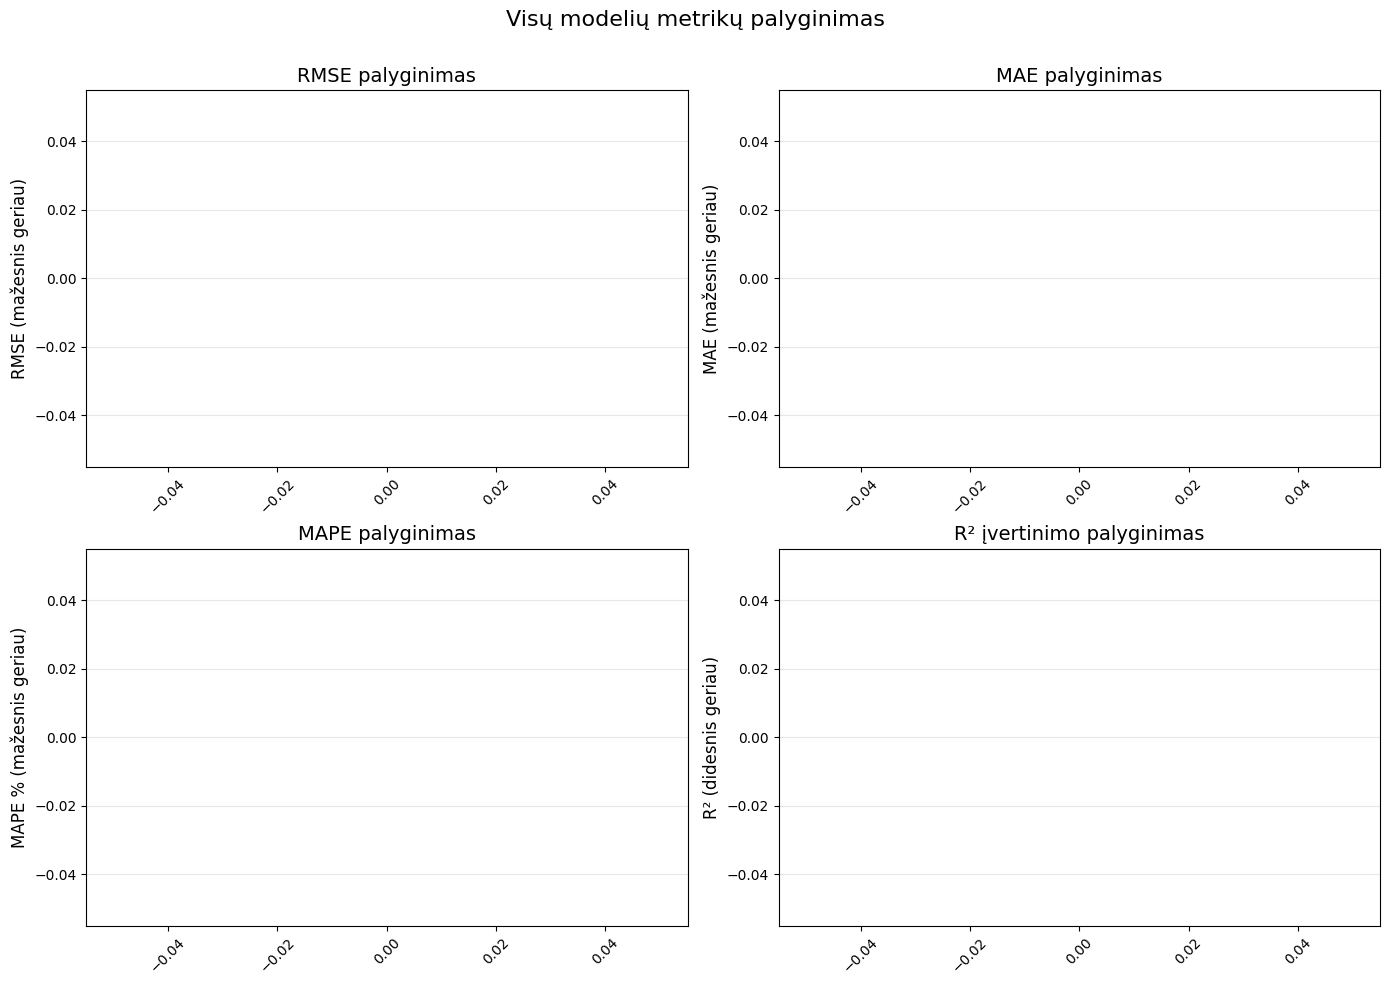

In [34]:
# --- 15. Stulpelinės diagramos palyginimas ---
plt.figure(figsize=(14, 10))
# Spalvos kiekvienam modeliui
colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

# RMSE palyginimas
plt.subplot(2, 2, 1)
bars = plt.bar(model_names, rmse_values, color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.2f}', ha='center', va='bottom')
plt.title('RMSE palyginimas', fontsize=14)
plt.ylabel('RMSE (mažesnis geriau)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# MAE palyginimas 
plt.subplot(2, 2, 2)
bars = plt.bar(model_names, mae_values, color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{height:.2f}', ha='center', va='bottom')
plt.title('MAE palyginimas', fontsize=14)
plt.ylabel('MAE (mažesnis geriau)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# MAPE palyginimas
plt.subplot(2, 2, 3)
bars = plt.bar(model_names, mape_values, color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height:.2f}%', ha='center', va='bottom')
plt.title('MAPE palyginimas', fontsize=14)
plt.ylabel('MAPE % (mažesnis geriau)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# R² palyginimas
plt.subplot(2, 2, 4)
bars = plt.bar(model_names, r2_values, color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.4f}', ha='center', va='bottom')
plt.title('R² įvertinimo palyginimas', fontsize=14)
plt.ylabel('R² (didesnis geriau)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Visų modelių metrikų palyginimas', fontsize=16)
plt.show()

In [35]:
# --- 16. Prognozių vizualizacija ---
if 'test_dates' in locals() and 'y_test_original' in locals():
    plt.figure(figsize=(16, 8))
    plt.plot(test_dates, y_test_original, label='Faktinė kaina', color='black', linewidth=2)
    
    # Pridedame visų modelių prognozes
    if lstm_available and lstm_preds_original is not None:
        plt.plot(test_dates, lstm_preds_original, label='LSTM prognozė', color='blue', linestyle='--')
    
    if gru_available and gru_preds_original is not None:
        plt.plot(test_dates, gru_preds_original, label='GRU prognozė', color='green', linestyle=':')
    
    if transformer_available and transformer_preds_original is not None:
        plt.plot(test_dates, transformer_preds_original, label='Transformer prognozė', color='red', linestyle='-.')
    
    if 'arima_available' in locals() and arima_available and 'arima_preds_original' in locals():
        plt.plot(test_dates, arima_preds_original, label='ARIMA prognozė', color='purple', linestyle='-')
    
    plt.title('Visų modelių prognozių palyginimas', fontsize=16)
    plt.xlabel('Data', fontsize=14)
    plt.ylabel('Bitcoin kaina (USD)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Nėra pakankamai duomenų vizualizacijos generavimui")

Nėra pakankamai duomenų vizualizacijos generavimui


In [36]:
# --- 17. Arti/toli prognozių palyginimas (paskutinės dienos) ---
if 'test_dates' in locals() and 'y_test_original' in locals():
    # Paimame paskutines 48 valandas (192 15min. intervalus)
    last_n = min(192, len(test_dates))
    
    plt.figure(figsize=(16, 8))
    plt.plot(test_dates[-last_n:], y_test_original[-last_n:], label='Faktinė kaina', color='black', linewidth=2)
    
    # Pridedame visų modelių prognozes
    if lstm_available and lstm_preds_original is not None:
        plt.plot(test_dates[-last_n:], lstm_preds_original[-last_n:], label='LSTM prognozė', color='blue', linestyle='--')
    
    if gru_available and gru_preds_original is not None:
        plt.plot(test_dates[-last_n:], gru_preds_original[-last_n:], label='GRU prognozė', color='green', linestyle=':')
    
    if transformer_available and transformer_preds_original is not None:
        plt.plot(test_dates[-last_n:], transformer_preds_original[-last_n:], label='Transformer prognozė', color='red', linestyle='-.')
    
    if 'arima_available' in locals() and arima_available and 'arima_preds_original' in locals():
        plt.plot(test_dates[-last_n:], arima_preds_original[-last_n:], label='ARIMA prognozė', color='purple', linestyle='-')
    
    plt.title('Modelių prognozių palyginimas (paskutinės 48 valandos)', fontsize=16)
    plt.xlabel('Data', fontsize=14)
    plt.ylabel('Bitcoin kaina (USD)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Nėra pakankamai duomenų detalesnei vizualizacijai")

Nėra pakankamai duomenų detalesnei vizualizacijai


In [37]:
# --- 18. Prognozių paklaidų vizualizacija ---
if 'test_dates' in locals() and 'y_test_original' in locals():
    plt.figure(figsize=(16, 8))
    
    # Apskaičiuojame paklaidas
    errors = {}
    
    if lstm_available and lstm_preds_original is not None:
        errors['LSTM'] = y_test_original - lstm_preds_original
        plt.plot(test_dates, errors['LSTM'], label='LSTM paklaida', color='blue')
    
    if gru_available and gru_preds_original is not None:
        errors['GRU'] = y_test_original - gru_preds_original
        plt.plot(test_dates, errors['GRU'], label='GRU paklaida', color='green')
    
    if transformer_available and transformer_preds_original is not None:
        errors['Transformer'] = y_test_original - transformer_preds_original
        plt.plot(test_dates, errors['Transformer'], label='Transformer paklaida', color='red')
    
    if 'arima_available' in locals() and arima_available and 'arima_preds_original' in locals():
        errors['ARIMA'] = y_test_original - arima_preds_original
        plt.plot(test_dates, errors['ARIMA'], label='ARIMA paklaida', color='purple')
    
    plt.title('Modelių prognozių paklaidos (faktinė - prognozė)', fontsize=16)
    plt.xlabel('Data', fontsize=14)
    plt.ylabel('Paklaida (USD)', fontsize=14)
    plt.axhline(y=0, color='black', linestyle='-')
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Paklaidos histograma
    if errors:
        fig, axs = plt.subplots(1, len(errors), figsize=(16, 6), sharey=True)
        if len(errors) == 1:
            axs = [axs]
            
        for i, (model_name, error) in enumerate(errors.items()):
            color = ['blue', 'green', 'red', 'purple'][i % 4]
            axs[i].hist(error, bins=30, alpha=0.7, color=color)
            axs[i].set_title(f'{model_name} paklaidos')
            axs[i].set_xlabel('Paklaida (USD)')
            axs[i].axvline(x=0, color='black', linestyle='--')
            if i == 0:
                axs[i].set_ylabel('Dažnis')
        
        plt.tight_layout()
        plt.show()
else:
    print("Nėra pakankamai duomenų paklaidų vizualizacijai")

Nėra pakankamai duomenų paklaidų vizualizacijai


In [38]:
# --- 19. Išvada ---
print("Modelių palyginimo išvada:")

if len(model_names) > 0:
    best_rmse_idx = rmse_values.index(min(rmse_values))
    best_mae_idx = mae_values.index(min(mae_values))
    best_mape_idx = mape_values.index(min(mape_values))
    best_r2_idx = r2_values.index(max(r2_values))
    
    best_models = {
        'RMSE': model_names[best_rmse_idx],
        'MAE': model_names[best_mae_idx],
        'MAPE': model_names[best_mape_idx],
        'R²': model_names[best_r2_idx]
    }
    
    print("\nGeriausi modeliai pagal kiekvieną metriką:")
    for metric, model in best_models.items():
        print(f"- {metric}: {model}")
    
    # Suskaičiuokime, kiek kartų kiekvienas modelis buvo geriausias
    best_count = {}
    for model in model_names:
        best_count[model] = list(best_models.values()).count(model)
    
    best_overall = max(best_count, key=best_count.get)
    print(f"\nBendrai geriausias modelis: {best_overall} (geriausias {best_count[best_overall]} iš 4 metrikų)")
else:
    print("Nėra pakankamai duomenų modelių palyginimui")

Modelių palyginimo išvada:
Nėra pakankamai duomenų modelių palyginimui
